#**Segmentation of RBCs using Mask RCNN**

In [1]:
#Installing Dependencies
!pip3 install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9MB 7.6MB/s 
     |████████████████████████████████| 15.7MB 194kB/s 
ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.21.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Found ex

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!git clone https://github.com/matterport/Mask_RCNN
%cd Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (562/562), done.
/content/Mask_RCNN


In [3]:
with open('mrcnn/model.py') as f:
    model_file = f.read()

with open('mrcnn/model.py', 'w') as f:
    model_file = model_file.replace("self.keras_model = self.build(mode=mode, config=config)",
                                    "self.keras_model = self.build(mode=mode, config=config)\n        self.keras_model.metrics_tensors = []")
    f.write(model_file)

In [4]:
!pip3 install -r requirements.txt
!python3 setup.py install

     |████████████████████████████████| 163kB 11.3MB/s 
     |████████████████████████████████| 204kB 40.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=718e07f5ecafbc1c9320d0cc1c7d435a1e5d27768e65c8b9ec8b8c5e8218686a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.2 which is incompatible.
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:694: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:694: UserWarning: Usage of dash-separated 'license-file' will not be supported in f

In [5]:
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cd ../../

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 31.26 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/Mask_RCNN/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/Mask_RCNN/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.

In [6]:
#importing the required modules and libraries
import os
import sys
import random
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [7]:
# Setting the root directory
ROOT_DIR = os.path.abspath("../")

In [8]:
# Importing Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

Using TensorFlow backend.


In [9]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [10]:
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [11]:
class BloodConfig(Config):
    # RBC detection configuratio 
    NAME = "blood_cell_detection"
    
    NUM_CLASSES = 1 + 3 #background + WBC RBC Platelets

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = BloodConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
#unzipping the data in google colab
!unzip "/content/blood-data.zip" -d "/content/Mask_RCNN/blood-data"

In [13]:
#Loading the dataset, masks and extracting the bounding boxes
class BloodDataset(utils.Dataset):
    def load_dataset(self, dataset_dir):
        self.add_class('dataset', 1, 'WBC')
        self.add_class('dataset', 2, 'RBC')
        self.add_class('dataset', 3, 'Platelets')
        
        # find all images
        for i, filename in enumerate(os.listdir(dataset_dir)):
            if '.jpg' in filename:
                self.add_image('dataset', 
                               image_id=i, 
                               path=os.path.join(dataset_dir, filename), 
                               annotation=os.path.join(dataset_dir, filename.replace('.jpg', '.xml')))
    
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ET.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = []
        classes = []
        for member in root.findall('object'):
            xmin = int(member[4][0].text)
            ymin = int(member[4][1].text)
            xmax = int(member[4][2].text)
            ymax = int(member[4][3].text)
            boxes.append([xmin, ymin, xmax, ymax])
            classes.append(self.class_names.index(member[0].text))
        # extract image dimensions
        width = int(root.find('size')[0].text)
        height = int(root.find('size')[1].text)
        return boxes, classes, width, height
 
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, classes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
        return masks, np.asarray(classes, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [14]:

# train set
dataset_train = BloodDataset()
dataset_train.load_dataset('/content/Mask_RCNN/blood-data/blood-data/train') #setting the path
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))
 
# validation set
dataset_val = BloodDataset()
dataset_val.load_dataset('/content/Mask_RCNN/blood-data/blood-data/test') #setting the path
dataset_val.prepare()
print('Test: %d' % len(dataset_val.image_ids))

Train: 323
Test: 20


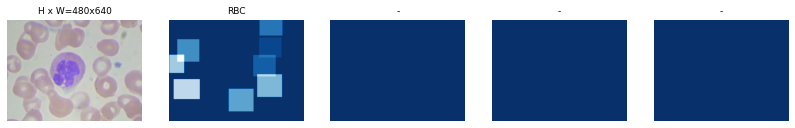

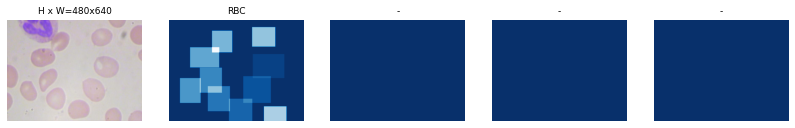

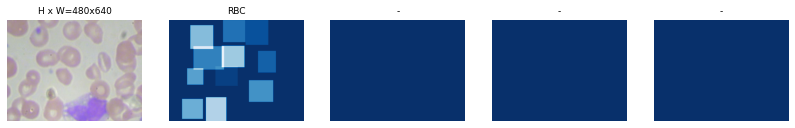

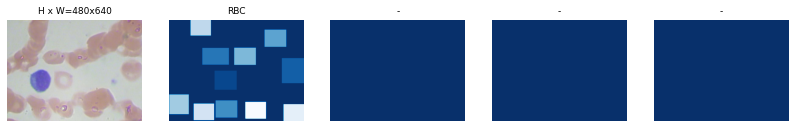

In [28]:
# Loading and displaying a few samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [16]:
# Creating the model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [17]:
# using coco's weight for the start, followed by imagenet and last
init_with = "coco"  

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

#**Training**

In [18]:
# Train the head branches
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/blood_cell_detection20210702T1636/mask_rcnn_blood_cell_detection_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribu

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-1.15.2/python3.7/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
1000/1000 [==============================] - 544s 544ms/step - loss: 0.9520 - val_loss: 0.7434

Epoch 2/10
1000/1000 [==============================] - 499s 499ms/step - loss: 0.7003 - val_loss: 0.7551
Epoch 3/10
1000/1000 [==============================] - 498s 498ms/step - loss: 0.6256 - val_loss: 0.5456
Epoch 4/10
1000/1000 [==============================] - 499s 499ms/step - loss: 0.5746 - val_loss: 0.5370
Epoch 5/10
1000/1000 [==============================] - 499s 499ms/step - loss: 0.5253 - val_loss: 0.7340
Epoch 6/10
1000/1000 [==============================] - 498s 498ms/step - loss: 0.4819 - val_loss: 0.8058
Epoch 7/10
1000/1000 [==============================] - 499s 499ms/step - loss: 0.4414 - val_loss: 0.3721
Epoch 8/10
1000/1000 [==============================] - 497s 497ms/step - loss: 0.4061 - val_loss: 0.7667
Epoch 9/10
1000/1000 [==============================] - 498s 498ms/step - loss: 0.3918 - val_loss: 0.8366
Epoch 10/10
1000/1000 [======================

**Calculating the mean avg precision obtained**

In [47]:
# Computing VOC-Style mAP @ IoU=0.5
# Running on the number of validation images
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.7900699830557607


**Detecting and Predictions**

In [19]:
class InferenceConfig(BloodConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreating the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Getting path to saved weights
# finding the last trained weights
model_path = model.find_last()

# Loading the trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/logs/blood_cell_detection20210702T1636/mask_rcnn_blood_cell_detection_0010.h5
Re-starting from epoch 10


In [24]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (7,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (7, 4)                min:  129.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000  uint8


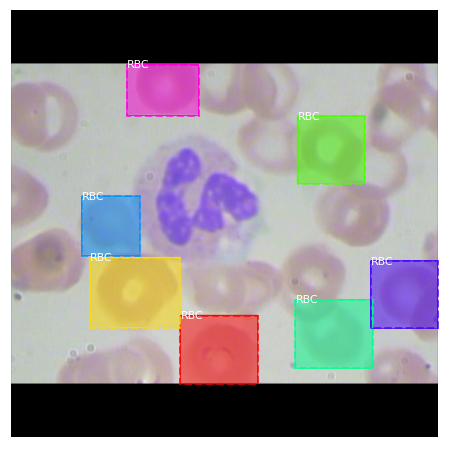

In [25]:
# Testing on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


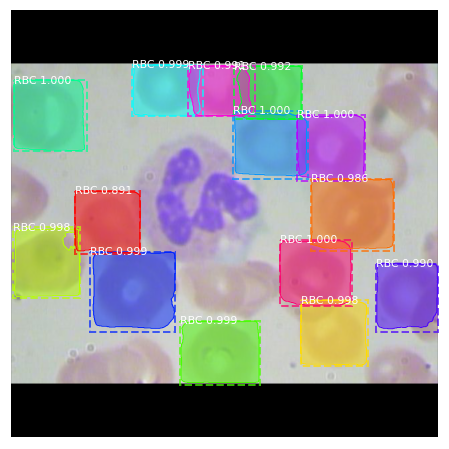

In [26]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())